In [49]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential , Input, layers , losses , optimizers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
from keras.layers import concatenate
from keras.layers import Input
from keras.optimizers import Adam, Adamax
from keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define data directories
data_dir = '../content/drive/MyDrive/chest_xray'
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [5]:
class_names = ['viral_pneumonia','normal', 'non_viral_pneumonia']

In [33]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
batch_size = 32
image_size = (224, 224)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_dataset = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5216 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [36]:
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)
num_classes = 3

In [37]:
# VGG19 Model
model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in model_vgg19.layers[:-4]:  # Fine-tune last 4 layers
    layer.trainable = False
vgg19_output = model_vgg19(input_layer)
vgg19_output = GlobalAveragePooling2D()(vgg19_output)
vgg19_output = Flatten()(vgg19_output)

In [38]:
# ResNet50 Model
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in model_resnet50.layers[:-4]:  # Fine-tune last 4 layers
    layer.trainable = False
resnet50_output = model_resnet50(input_layer)
resnet50_output = GlobalAveragePooling2D()(resnet50_output)
resnet50_output = Flatten()(resnet50_output)

In [39]:
merged = concatenate([vgg19_output, resnet50_output])
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
final_output = Dense(num_classes, activation='softmax')(merged)

In [40]:
stacked_model = Model(inputs=input_layer, outputs=final_output)

In [41]:
optm = Adam(learning_rate=0.0001)
stacked_model.compile(loss='categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [45]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)
class_weights = dict(enumerate(class_weights))



In [52]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint('./stacked_modelx.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [53]:
history = stacked_model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.6794
Epoch 1: val_loss improved from inf to 1.22886, saving model to ./stacked_modelx.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 659s 4s/step - loss: 0.7214 - accuracy: 0.6794 - val_loss: 1.2289 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.7086
Epoch 2: val_loss improved from 1.22886 to 0.73511, saving model to ./stacked_modelx.h5
163/163 [==============================] - 227s 1s/step - loss: 0.6505 - accuracy: 0.7086 - val_loss: 0.7351 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.7322
Epoch 3: val_loss did not improve from 0.73511
163/163 [==============================] - 233s 1s/step - loss: 0.5913 - accuracy: 0.7322 - val_loss: 1.2623 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.7260
Epoch 4: val_loss did not improve from 0.73511
163/163 [==============================] - 229s 1s/step - loss: 0.5732 - accuracy: 

In [54]:
stacked_model.save('/content/drive/MyDrive/stacked_modelx.h5')

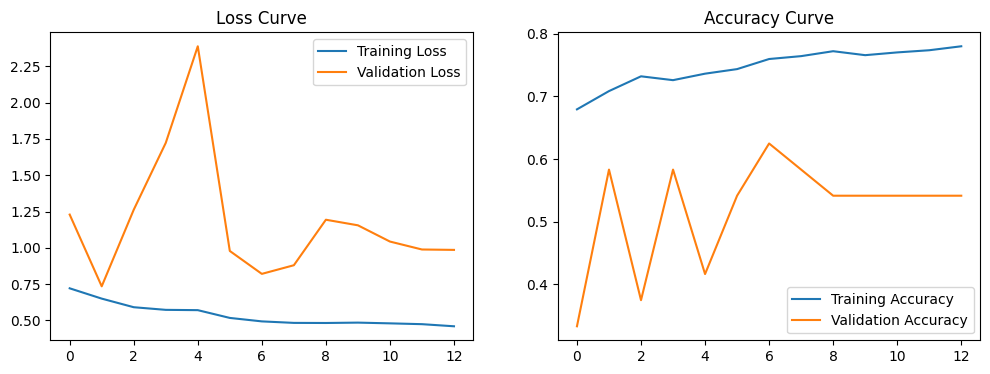

In [55]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Evaluate the model on the test dataset
test_loss, test_accuracy = stacked_model.evaluate(test_dataset)

# Get the predicted probabilities for each class
y_pred_prob = stacked_model.predict(test_dataset)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = test_dataset.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


20/20 [==============================] - 22s 1s/step - loss: 0.4655 - accuracy: 0.8526


20/20 [==============================] - 24s 1s/step
Test Accuracy: 0.8525641025641025
Precision: 0.8447734565970412
Recall: 0.8346512437421528


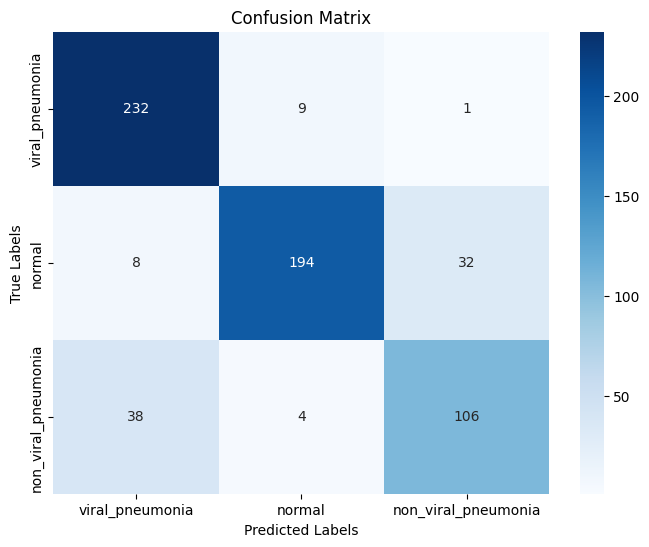

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [58]:
def predict_single_image(image_path, class_names):
    # Load the model
    model = tf.keras.models.load_model('stacked_modelx.h5')

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)[0]

    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Get the confidence score for the predicted class
    confidence_score = predictions[predicted_class_index]

    return predicted_class, confidence_score

# Example usage:
image_path = '/content/drive/My Drive/chest_xray/test/normal/IM-0005-0001.jpeg'
predicted_class, confidence_score = predict_single_image(image_path, class_names)
print("Predicted Class:", predicted_class)
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 1s/step
Predicted Class: normal
Confidence Score: 1.0


In [59]:
image_path = '/content/drive/My Drive/chest_xray/test/viral_pneumonia/person1_virus_9.jpeg'
predicted_class, confidence_score = predict_single_image(image_path, class_names)
print("Predicted Class:", predicted_class)
print("Confidence Score:", confidence_score)

1/1 [==============================] - 1s 1s/step
Predicted Class: viral_pneumonia
Confidence Score: 1.0


In [64]:
image_path = '/content/drive/My Drive/chest_xray/test/non_viral_pneumonia/person78_bacteria_386.jpeg'
predicted_class, confidence_score = predict_single_image(image_path, class_names)
print("Predicted Class:", predicted_class)
print("Confidence Score:", confidence_score)

1/1 [==============================] - 1s 1s/step
Predicted Class: normal
Confidence Score: 0.8805721


In [65]:
import json

# Convert model architecture to JSON string
model_json = stacked_model.to_json()

# Save JSON string to a file
with open('/content/drive/My Drive/vgg19_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

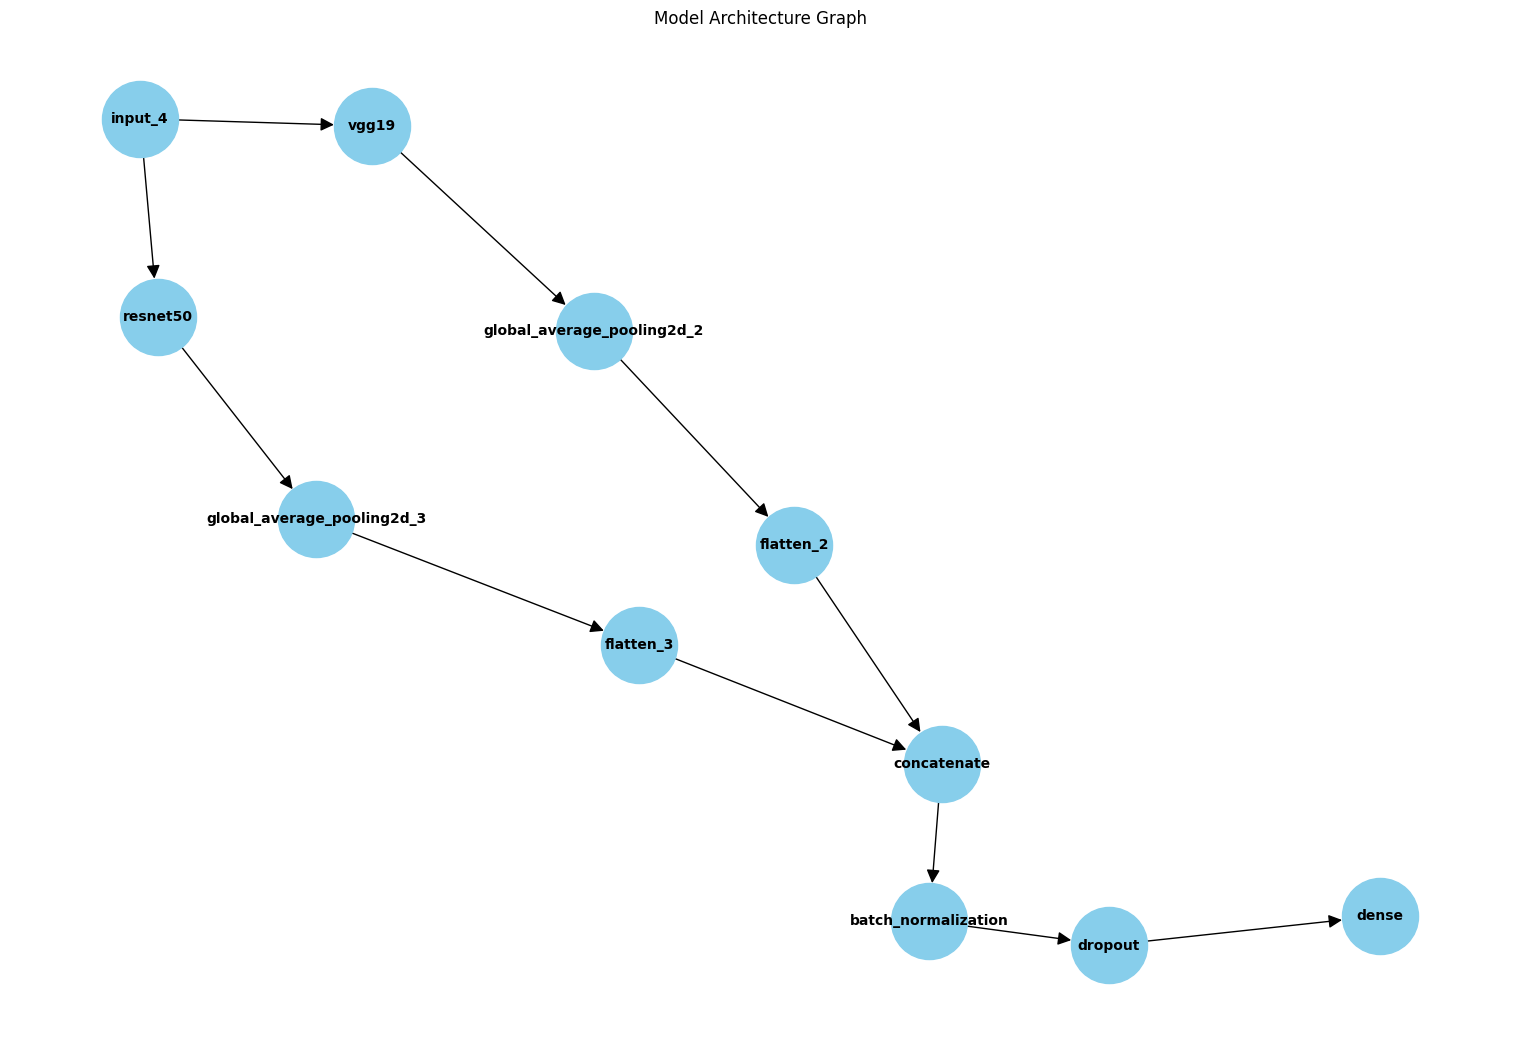

In [67]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the JSON file containing the model architecture
with open('/content/drive/My Drive/vgg19_model_architecture.json', 'r') as json_file:
    model_json = json_file.read()

# Parse the JSON data
model_data = json.loads(model_json)

# Create a directed graph
graph = nx.DiGraph()

# Add nodes (layers) to the graph
for layer in model_data['config']['layers']:
    graph.add_node(layer['name'])

# Add edges (connections between layers)
for layer in model_data['config']['layers']:
    if 'inbound_nodes' in layer and len(layer['inbound_nodes']) > 0:
        for inbound_node in layer['inbound_nodes'][0]:
            graph.add_edge(inbound_node[0], layer['name'])

# Visualize the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title('Model Architecture Graph')
plt.savefig('/content/drive/My Drive/ensemble_model_architecture.png')
plt.show()


In [70]:
def print_model_summary(model):
    print("Model Architecture:")
    print("-------------------")
    for layer in model.layers:
        if hasattr(layer, 'layers'):

            print(f"\n{layer.name.upper()} (Nested Model):")
            for sublayer in layer.layers:
                sub_layer_type = type(sublayer).__name__
                sub_layer_output_shape = sublayer.output_shape
                print(f"{sub_layer_type:20} output shape: {sub_layer_output_shape}")
        else:
            layer_type = type(layer).__name__
            layer_output_shape = layer.output_shape
            print(f"{layer_type:20} output shape: {layer_output_shape}")

print_model_summary(stacked_model)



Model Architecture:
-------------------
InputLayer           output shape: [(None, 224, 224, 3)]

VGG19 (Nested Model):
InputLayer           output shape: [(None, 224, 224, 3)]
Conv2D               output shape: (None, 224, 224, 64)
Conv2D               output shape: (None, 224, 224, 64)
MaxPooling2D         output shape: (None, 112, 112, 64)
Conv2D               output shape: (None, 112, 112, 128)
Conv2D               output shape: (None, 112, 112, 128)
MaxPooling2D         output shape: (None, 56, 56, 128)
Conv2D               output shape: (None, 56, 56, 256)
Conv2D               output shape: (None, 56, 56, 256)
Conv2D               output shape: (None, 56, 56, 256)
Conv2D               output shape: (None, 56, 56, 256)
MaxPooling2D         output shape: (None, 28, 28, 256)
Conv2D               output shape: (None, 28, 28, 512)
Conv2D               output shape: (None, 28, 28, 512)
Conv2D               output shape: (None, 28, 28, 512)
Conv2D               output shape: (None, 28, 

In [85]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [86]:
!pip install pydot

In [89]:
input_layer = Input(shape=(224, 224, 3))
